In [10]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
import numpy as np 


# symbol
symbols = ['USDT','USDC','DAI'] 
scale = True

for s in symbols:
    # data = pd.read_csv('{}_regression_data.csv'.format(s))
    data = pd.read_csv('panel_regression_data_stage2.csv')
    data = data[data['stablecoin']==s].dropna()
    
    lags = [1]
    # feature construction
    data['volatility_t-1'] = data['volatility'].shift(1)
    data['face_values'] = (data['marketcap']/data['close']).apply(np.log)
    data['net_issuance'] = data['face_values'].diff()
    
    # choose regressors: easily modify this list to change the number of regressors
    regressors = []
    for l in lags:
        data['net_issuance_lag{}'.format(l)] = data['net_issuance'].shift(l)
        regressors.append('net_issuance_lag{}'.format(l))
        data['funding_lag{}'.format(l)] = data['funding'].shift(l)
        regressors.append('funding_lag{}'.format(l))
        data['face_values_lag{}'.format(l)] = data['net_issuance'].shift(l)
        regressors.append('face_values_lag{}'.format(l))
        data['net_issuance_rolling_lag{}'.format(l)] = data['net_issuance'].shift(l).rolling(l).mean()
        data['face_values_rolling_lag{}'.format(l)] = data['net_issuance'].shift(l).rolling(l).mean()
        data['BTC_Aret_lag{}'.format(l)] = data['BTC_Aret'].shift(l)
        regressors.append('BTC_Aret_lag{}'.format(l))
        data['BTC_RV_lag{}'.format(l)] = data['BTC_RV'].shift(l)
        regressors.append('BTC_RV_lag{}'.format(l))
        data['ETH_Aret_lag{}'.format(l)] = data['ETH_Aret'].shift(l)
        regressors.append('ETH_Aret_lag{}'.format(l))
        data['ETH_RV_lag{}'.format(l)] = data['ETH_RV'].shift(l)
        regressors.append('ETH_RV_lag{}'.format(l))
    # Drop the rows with NaN due to differencing
    data = data.dropna()
    

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

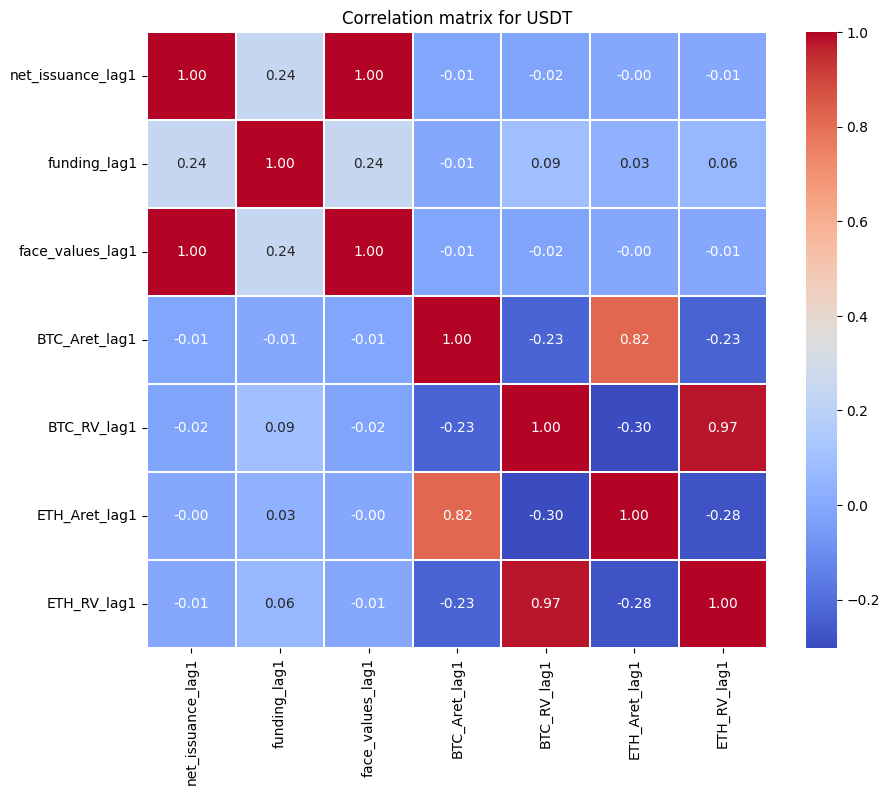

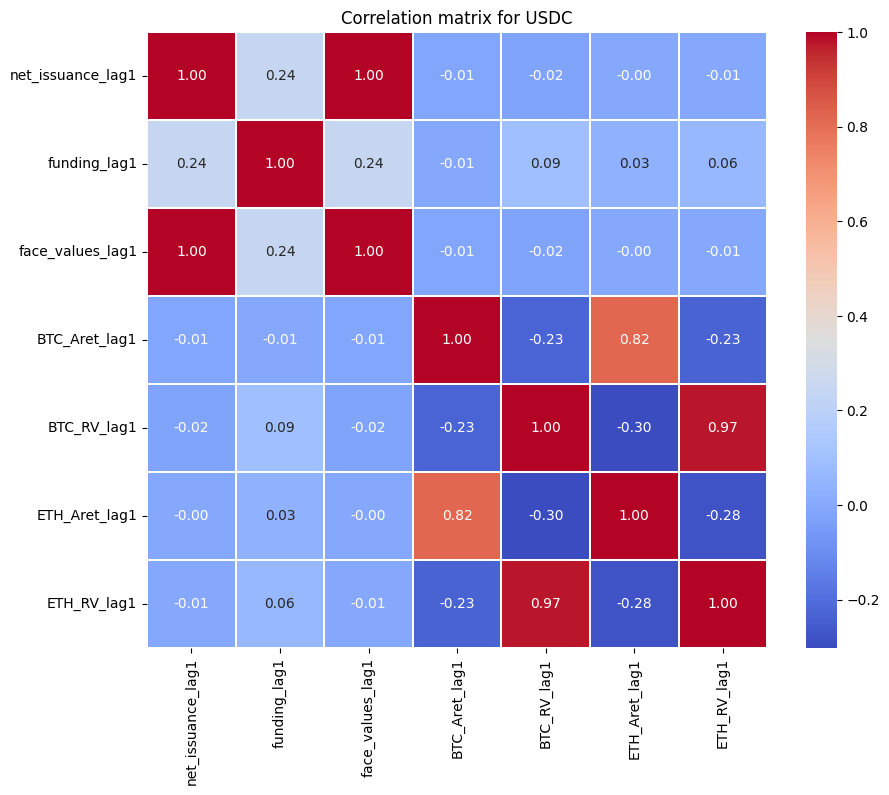

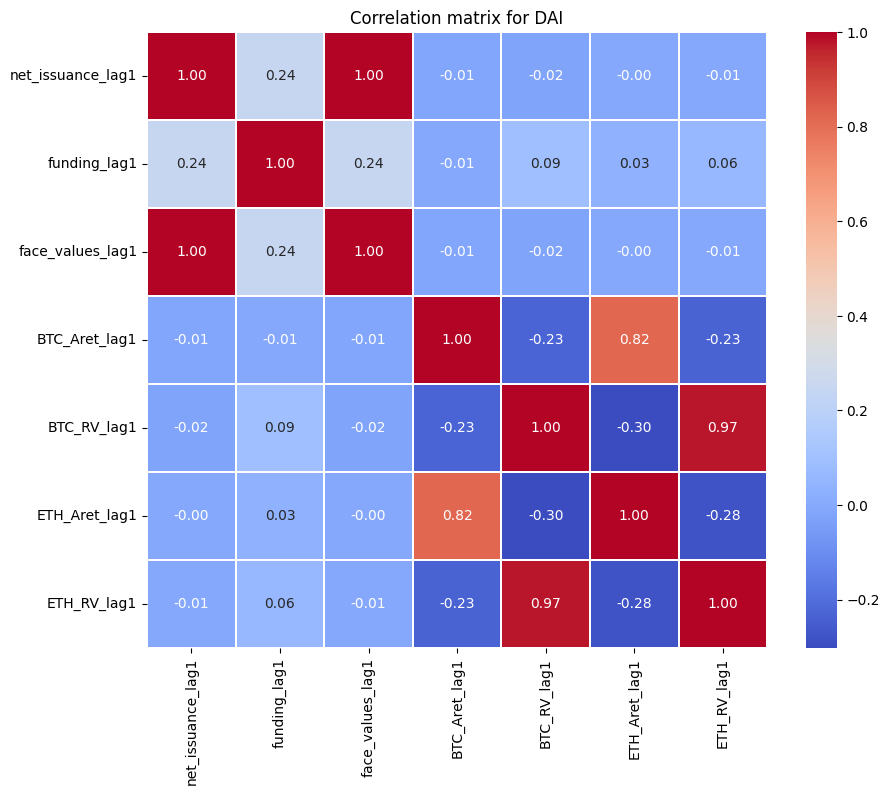

In [12]:
for s in symbols:
    corr_matrix = data[regressors].corr()

    # Plot correlation matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.1)
    plt.title('Correlation matrix for {}'.format(s))
    plt.show()

In [17]:

for s in symbols:
    X = data[regressors] 
    y = data['net_issuance']

    # decide if standardizing variables
    if scale:
        scaler = StandardScaler()
        X = scaler.fit_transform(X)

    # add constant
    X = sm.add_constant(X)
    # loading everything back into a df so we will have names in the OLS summary
    if scale:
        X = pd.DataFrame(X,columns=['constant']+regressors,index=y.index)

    # estimate regression
    model = sm.OLS(y, X)
    results = model.fit()

    # print summary
    print('Regression results for {}'.format(s))
    print(results.summary())
    print()

    predicted_y = results.predict(X)

    data['predicted_net_issuance'] = predicted_y

    # Next regression's dependent variable (delta_lending)
    data['delta_lending'] = data['lending'].diff()
    data = data.dropna()

    # Prepare the data for the next regression
    next_X = data['predicted_net_issuance']
    next_y = data['delta_lending']

    # Add constant column
    next_X = sm.add_constant(next_X)

    # Perform the next regression
    next_model = sm.OLS(next_y, next_X)
    next_results = next_model.fit()

    # Print results
    print('Regression results for second stage')
    print(next_results.summary())

Regression results for USDT
                            OLS Regression Results                            
Dep. Variable:           net_issuance   R-squared:                       0.125
Model:                            OLS   Adj. R-squared:                  0.121
Method:                 Least Squares   F-statistic:                     31.48
Date:                Wed, 12 Jul 2023   Prob (F-statistic):           4.89e-19
Time:                        15:00:20   Log-Likelihood:                 2487.7
No. Observations:                 668   AIC:                            -4967.
Df Residuals:                     664   BIC:                            -4949.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
constant  